# Klasifikasi Sentimen Ujaran Kebencian Terhadap Agama Islam Pada Platform Twitter Menggunakan Multinomial Naive Bayes

Proyek ini dibuat oleh
- Nama: Zul Iflah Al Juhaeda
- NIM: 200605110139

### 6.1. Import Library dan Modul

Pada bagian ini, kita mengimpor semua library dan modul yang dibutuhkan untuk proyek ini, termasuk modul yang telah kita buat seperti `utils.py`, `preprocessing.py`, `mnb.py`, dan `visualization.py`.


In [1]:
import pandas as pd
import numpy as np
import logging
import matplotlib.pyplot as plt
import seaborn as sns  
import sys
import random


from utils import setup_logging, set_seed
from preprocessing import preprocess_text, remove_emoji, clean_text, replace_words, tokenize_text, remove_stopwords, stem_text
from mnb import train_mnb_with_grid_search, evaluate_model, perform_cross_validation, save_model
from visualization import generate_wordcloud_top_words, plot_confusion_matrix

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay  # Tambahkan ini
from sklearn.naive_bayes import MultinomialNB

sns.set_theme()


### 6.2. Setup Logging dan Random Seed

Kita mengatur logging untuk memantau jalannya proses dan mengatur seed random untuk memastikan hasil yang konsisten setiap kali kode dijalankan.


In [2]:
setup_logging()
logger = logging.getLogger(__name__)

set_seed(42)


### 6.3. Memuat Dataset

Di bagian ini, memuat dataset dari file `dataset.xlsx` dan memastikan bahwa data tersebut bebas dari nilai kosong dan duplikasi yang dapat mempengaruhi analisis.


In [3]:
logger.info('Memuat dataset.')
try:
    df = pd.read_excel('data/dataset.xlsx')
    logger.info('Dataset berhasil dimuat.')
except FileNotFoundError:
    logger.error('File dataset tidak ditemukan.')
    raise

# Menghapus nilai kosong dan duplikasi
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

# Menampilkan head dari dataset
print('Data Awal:')
display(df.head())


10-25 22:52 __main__     INFO     Memuat dataset.
10-25 22:52 __main__     INFO     Dataset berhasil dimuat.
Data Awal:


,full_text,kelas
0,@Buahterlar42596 @aprimayoga19 Jancuk'an Wong ...,Negatif
1,Eng Ing Eeeeng ... Semoga para biadab yg mempe...,Positif
2,@suleizdn @umarfaruqi_SHI @Generasi_MudaNU orm...,Negatif
3,@denismalhotra Mreka kan kturunan yahudi pesek...,Negatif
4,@bctnakal @_faktaindo ajaran islam memang biad...,Negatif


### 6.4. Eksplorasi Dataset

Eksplorasi awal untuk memahami distribusi kelas dalam dataset dan memastikan bahwa tidak ada masalah pada data yang akan digunakan.


10-25 22:52 __main__     INFO     Melakukan eksplorasi data.
Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
Index: 1190 entries, 0 to 1198
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   full_text  1190 non-null   object
 1   kelas      1190 non-null   object
dtypes: object(2)
memory usage: 27.9+ KB


None


Distribusi Kelas:
kelas
Negatif    995
Positif    195
Name: count, dtype: int64


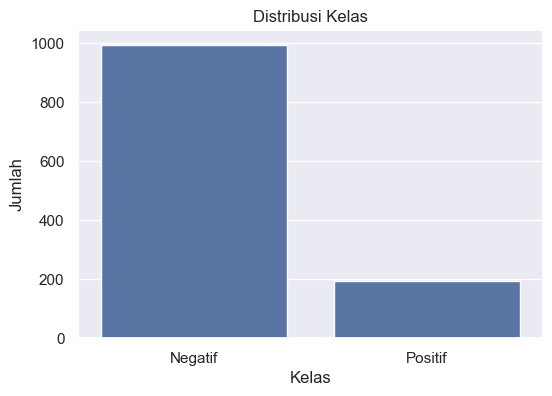

In [4]:
logger.info('Melakukan eksplorasi data.')

# Menampilkan informasi dataset
print('Informasi Dataset:')
display(df.info())

# Menampilkan distribusi kelas
class_counts = df['kelas'].value_counts()
print('\nDistribusi Kelas:')
print(class_counts)

# Visualisasi distribusi kelas
plt.figure(figsize=(6,4))
sns.countplot(x='kelas', data=df)
plt.title('Distribusi Kelas')
plt.xlabel('Kelas')
plt.ylabel('Jumlah')
plt.show()


### 6.5. Pembagian Data

Sebelum melakukan preprocessing dan ekstraksi fitur, akan dilakukan pembagian data menjadi set pelatihan dan pengujian untuk menghindari data leakage. Pembagian data dilakukan dengan rasio yang ditentukan (70:30, 80:20, 90:10).


In [5]:
logger.info('Membagi data menjadi training dan testing set.')

# Daftar untuk menyimpan data split
data_splits = []
test_sizes = [0.3, 0.2, 0.1]

for test_size in test_sizes:
    train_size = 1 - test_size
    ratio = f"{int(train_size*100)}:{int(test_size*100)}"
    logger.info(f'Pembagian data dengan rasio {ratio}')
    
    X = df['full_text']  
    y = df['kelas']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=42)
    
    # Menyimpan data split
    data_splits.append({
        'ratio': ratio,
        'X_train': X_train.reset_index(drop=True),
        'X_test': X_test.reset_index(drop=True),
        'y_train': y_train.reset_index(drop=True),
        'y_test': y_test.reset_index(drop=True)
    })
    
    # Menampilkan distribusi kelas
    print(f'\nRasio {ratio}')
    print('Distribusi Kelas pada Training Set:')
    print(y_train.value_counts())
    print('\nDistribusi Kelas pada Testing Set:')
    print(y_test.value_counts())


10-25 22:52 __main__     INFO     Membagi data menjadi training dan testing set.
10-25 22:52 __main__     INFO     Pembagian data dengan rasio 70:30

Rasio 70:30
Distribusi Kelas pada Training Set:
kelas
Negatif    696
Positif    137
Name: count, dtype: int64

Distribusi Kelas pada Testing Set:
kelas
Negatif    299
Positif     58
Name: count, dtype: int64
10-25 22:52 __main__     INFO     Pembagian data dengan rasio 80:20

Rasio 80:20
Distribusi Kelas pada Training Set:
kelas
Negatif    796
Positif    156
Name: count, dtype: int64

Distribusi Kelas pada Testing Set:
kelas
Negatif    199
Positif     39
Name: count, dtype: int64
10-25 22:52 __main__     INFO     Pembagian data dengan rasio 90:10

Rasio 90:10
Distribusi Kelas pada Training Set:
kelas
Negatif    895
Positif    176
Name: count, dtype: int64

Distribusi Kelas pada Testing Set:
kelas
Negatif    100
Positif     19
Name: count, dtype: int64


### 6.6. Preprocessing

Setelah data dibagi, melakukan preprocessing pada data pelatihan dan data pengujian secara terpisah untuk menghindari data leakage. Pada tahap ini, kita menggunakan modul `preprocessing.py` yang telah dibuat sebelumnya. Langkah-langkah preprocessing meliputi:

1. **Cleaning**
2. **Case Folding**
3. **Tokenisasi**
4. **Mengganti Kata**
5. **Penghapusan Stopword**
6. **Stemming**

Kita juga menyimpan hasil setiap tahap preprocessing dalam dataframe untuk melihat transformasi data.


In [6]:
for split_data in data_splits:
    ratio = split_data['ratio']
    X_train = split_data['X_train']
    X_test = split_data['X_test']
    
    print(f"\n=== Preprocessing untuk Rasio Data {ratio} ===")
    
    # Preprocessing pada data pelatihan
    logger.info(f'Preprocessing data pelatihan untuk rasio {ratio}')
    df_train_preprocessed = pd.DataFrame()
    df_train_preprocessed['original_text'] = X_train
    df_train_preprocessed['no_emoji'] = df_train_preprocessed['original_text'].apply(remove_emoji)
    df_train_preprocessed['cleaned_text'] = df_train_preprocessed['no_emoji'].apply(clean_text)
    df_train_preprocessed['lower_text'] = df_train_preprocessed['cleaned_text'].str.lower()
    df_train_preprocessed['replaced_text'] = df_train_preprocessed['lower_text'].apply(replace_words)
    df_train_preprocessed['tokens'] = df_train_preprocessed['replaced_text'].apply(tokenize_text)
    df_train_preprocessed['no_stopwords'] = df_train_preprocessed['tokens'].apply(remove_stopwords)
    df_train_preprocessed['stemmed_tokens'] = df_train_preprocessed['no_stopwords'].apply(stem_text)
    df_train_preprocessed['processed_text'] = df_train_preprocessed['stemmed_tokens'].apply(lambda x: ' '.join(x))
    
    # Menyimpan hasil preprocessing data pelatihan
    split_data['X_train_processed'] = df_train_preprocessed['processed_text']
    split_data['df_train_preprocessed'] = df_train_preprocessed
    
    # Preprocessing pada data pengujian
    logger.info(f'Preprocessing data pengujian untuk rasio {ratio}')
    df_test_preprocessed = pd.DataFrame()
    df_test_preprocessed['original_text'] = X_test
    df_test_preprocessed['no_emoji'] = df_test_preprocessed['original_text'].apply(remove_emoji)
    df_test_preprocessed['cleaned_text'] = df_test_preprocessed['no_emoji'].apply(clean_text)
    df_test_preprocessed['lower_text'] = df_test_preprocessed['cleaned_text'].str.lower()
    df_test_preprocessed['replaced_text'] = df_test_preprocessed['lower_text'].apply(replace_words)
    df_test_preprocessed['tokens'] = df_test_preprocessed['replaced_text'].apply(tokenize_text)
    df_test_preprocessed['no_stopwords'] = df_test_preprocessed['tokens'].apply(remove_stopwords)
    df_test_preprocessed['stemmed_tokens'] = df_test_preprocessed['no_stopwords'].apply(stem_text)
    df_test_preprocessed['processed_text'] = df_test_preprocessed['stemmed_tokens'].apply(lambda x: ' '.join(x))
    
    # Menyimpan hasil preprocessing data pengujian
    split_data['X_test_processed'] = df_test_preprocessed['processed_text']
    split_data['df_test_preprocessed'] = df_test_preprocessed
    
    # Menampilkan hasil preprocessing data pelatihan (contoh)
    print('Hasil Preprocessing Data Pelatihan:')
    display(df_train_preprocessed[['original_text', 'cleaned_text', 'lower_text', 'tokens', 'no_stopwords', 'stemmed_tokens', 'processed_text']].head());



=== Preprocessing untuk Rasio Data 70:30 ===
10-25 22:52 __main__     INFO     Preprocessing data pelatihan untuk rasio 70:30
10-25 22:56 __main__     INFO     Preprocessing data pengujian untuk rasio 70:30
Hasil Preprocessing Data Pelatihan:


,original_text,cleaned_text,lower_text,tokens,no_stopwords,stemmed_tokens,processed_text
0,https://t.co/MGmrRyoNk8 Pengen gw ghoh roghk s...,Pengen gw ghoh roghk si ali jindan ini SUMPAH ...,pengen gw ghoh roghk si ali jindan ini sumpah ...,"[pengen, gw, ghoh, roghk, si, ali, jindan, ini...","[pengen, gw, ghoh, roghk, si, ali, jindan, sum...","[ken, gw, ghoh, roghk, si, ali, jindan, sumpah...",ken gw ghoh roghk si ali jindan sumpah mnurut ...
1,@DanYamYam @BuddhisGL @GlHindu @violettapadma_...,Aaaa purapura kulit bia Islam stereotip di kom...,aaaa purapura kulit bia islam stereotip di kom...,"[aaaa, purapura, kulit, bia, islam, stereotip,...","[aaaa, purapura, kulit, bia, islam, stereotip,...","[aaaa, purapura, kulit, bia, islam, stereotip,...",aaaa purapura kulit bia islam stereotip komuni...
2,as acehnese yang dianggap islam radikal dan ko...,as acehnese yang dianggap islam radikal dan ko...,as acehnese yang dianggap islam radikal dan ko...,"[as, acehnese, yang, dianggap, islam, radikal,...","[as, acehnese, dianggap, islam, radikal, konse...","[as, acehnese, anggap, islam, radikal, konserv...",as acehnese anggap islam radikal konservatif s...
3,Alasan saya terkadang membenci label pendukung...,Alasan saya terkadang membenci label pendukung...,alasan saya terkadang membenci label pendukung...,"[alasan, saya, terkadang, membenci, label, pen...","[alasan, terkadang, membenci, label, pendukung...","[alas, terkadang, benci, label, dukung, abw, a...",alas terkadang benci label dukung abw asosiasi...
4,Banyak yang tersinggung jika wahabi disebut ra...,Banyak yang tersinggung jika wahabi disebut ra...,banyak yang tersinggung jika wahabi disebut ra...,"[banyak, yang, tersinggung, jika, wahabi, dise...","[banyak, tersinggung, wahabi, disebut, radikal...","[banyak, singgung, wahabi, sebut, radikal, mot...",banyak singgung wahabi sebut radikal motivasi ...



=== Preprocessing untuk Rasio Data 80:20 ===
10-25 22:57 __main__     INFO     Preprocessing data pelatihan untuk rasio 80:20
10-25 22:57 __main__     INFO     Preprocessing data pengujian untuk rasio 80:20
Hasil Preprocessing Data Pelatihan:


,original_text,cleaned_text,lower_text,tokens,no_stopwords,stemmed_tokens,processed_text
0,@melodramaperte @AyaniMel Jangan bikin malu ag...,Jangan bikin malu agama Jangan rasis dan intol...,jangan bikin malu agama jangan rasis dan intol...,"[jangan, bikin, malu, agama, jangan, rasis, da...","[jangan, bikin, malu, agama, jangan, rasis, in...","[jangan, bikin, malu, agama, jangan, ras, into...",jangan bikin malu agama jangan ras intoleran a...
1,MARI DOAKAN: Penyampaian keras kepada Islam R...,MARI DOAKAN Penyampaian keras kepada Islam Rad...,mari doakan penyampaian keras kepada islam rad...,"[mari, doakan, penyampaian, keras, kepada, isl...","[doakan, penyampaian, keras, islam, radikal, p...","[doa, sampai, keras, islam, radikal, anut, ide...",doa sampai keras islam radikal anut ideologi i...
2,@luxentX klau x ambil tindakkan akan dtg org l...,klau x ambil tindakkan akan dtg org lain pulak...,klau x ambil tindakkan akan dtg org lain pulak...,"[klau, x, ambil, tindakkan, akan, dtg, orang, ...","[klau, x, ambil, tindakkan, dtg, orang, pulak,...","[klau, x, ambil, tindak, dtg, orang, pulak, bu...",klau x ambil tindak dtg orang pulak buat mcm t...
3,Berpikirlah positif dan berjiwa besar. Tidak ...,Berpikirlah positif dan berjiwa besar Tidak us...,berpikirlah positif dan berjiwa besar tidak us...,"[berpikirlah, positif, dan, berjiwa, besar, ti...","[berpikirlah, positif, berjiwa, besar, usah, m...","[pikir, positif, jiwa, besar, usah, rendah, or...",pikir positif jiwa besar usah rendah orang sam...
4,@Mohadongu @nurbaut80 @Y_D_Y_P @sukolilo Ya ng...,Ya ngapain Dagestan dikatain penghianat sejak ...,ya ngapain dagestan dikatain penghianat sejak ...,"[ya, ngapain, dagestan, dikatain, penghianat, ...","[ngapain, dagestan, dikatain, penghianat, seja...","[ngapain, dagestan, dikatain, penghianat, seja...",ngapain dagestan dikatain penghianat sejak per...



=== Preprocessing untuk Rasio Data 90:10 ===
10-25 22:57 __main__     INFO     Preprocessing data pelatihan untuk rasio 90:10
10-25 22:57 __main__     INFO     Preprocessing data pengujian untuk rasio 90:10
Hasil Preprocessing Data Pelatihan:


,original_text,cleaned_text,lower_text,tokens,no_stopwords,stemmed_tokens,processed_text
0,@dependentbeing Nah!!!! mirip radikal islam,Nah mirip radikal islam,nah mirip radikal islam,"[nah, mirip, radikal, islam]","[nah, mirip, radikal, islam]","[nah, mirip, radikal, islam]",nah mirip radikal islam
1,@mollibanriize Islam tp rasis,Islam tp rasis,islam tp rasis,"[islam, tapi, rasis]","[islam, rasis]","[islam, ras]",islam ras
2,@ardianroe @creepylogy_ @ggwp910 Gak dukung fp...,Gak dukung fpi tapi mereka layak dapet keadila...,gak dukung fpi tapi mereka layak dapet keadila...,"[tidak, dukung, fpi, tapi, mereka, layak, dape...","[dukung, fpi, layak, dapet, keadilan, sih, ter...","[dukung, fpi, layak, dapet, adil, sih, utama, ...",dukung fpi layak dapet adil sih utama masalah ...
3,@mattekudasaiiii @onthesbrew Kalo rasis ke jaw...,Kalo rasis ke jawe ga cuma orang Jawa aja poko...,kalo rasis ke jawe ga cuma orang jawa aja poko...,"[kalau, rasis, ke, jawe, tidak, cuma, orang, j...","[kalau, rasis, jawe, cuma, orang, jawa, pokokn...","[kalau, ras, jawe, cuma, orang, jawa, pokok, o...",kalau ras jawe cuma orang jawa pokok orang aus...
4,@LeeAn21_ @bibforsure @tanyarlfes 1. Mereka ra...,Mereka rasis ke China anggapannya komunis misk...,mereka rasis ke china anggapannya komunis misk...,"[mereka, rasis, ke, china, anggapannya, komuni...","[rasis, china, anggapannya, komunis, miskin, b...","[ras, china, anggap, komunis, miskin, biadab, ...",ras china anggap komunis miskin biadab jepang ...


### 6.7. Ekstraksi Fitur dengan Bag of Words

Setelah preprocessing, kita melakukan ekstraksi fitur menggunakan metode Bag of Words. Penting untuk melakukan `fit` pada `CountVectorizer` menggunakan data pelatihan saja dan kemudian melakukan `transform` pada data pengujian.


In [7]:
# 6.7. Ekstraksi Fitur dengan Bag of Words

import os
import pickle  # Pastikan Anda telah mengimpor modul pickle

# Membuat direktori saved_models jika belum ada
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')

vectorizers = {}

for split_data in data_splits:
    ratio = split_data['ratio']
    X_train_processed = split_data['X_train_processed']
    X_test_processed = split_data['X_test_processed']
    
    print(f"\n=== Ekstraksi Fitur Bag of Words untuk Rasio Data {ratio} ===")
    
    # Inisialisasi CountVectorizer
    vectorizer = CountVectorizer(ngram_range=(1,2), max_features=5000)
    
    # Fit pada data pelatihan
    X_train_vec = vectorizer.fit_transform(X_train_processed)
    split_data['X_train_vec'] = X_train_vec
    
    # Transform pada data pengujian
    X_test_vec = vectorizer.transform(X_test_processed)
    split_data['X_test_vec'] = X_test_vec
    
    # Menyimpan vectorizer
    vectorizers[ratio] = vectorizer
    
    # Menyimpan vectorizer ke file (contoh untuk rasio 70:30)
    if ratio == '70:30':
        vectorizer_path = 'saved_models/vectorizer.pkl'
        with open(vectorizer_path, 'wb') as f:
            pickle.dump(vectorizer, f)
        print(f"Vectorizer disimpan di {vectorizer_path}")



=== Ekstraksi Fitur Bag of Words untuk Rasio Data 70:30 ===
Vectorizer disimpan di saved_models/vectorizer.pkl

=== Ekstraksi Fitur Bag of Words untuk Rasio Data 80:20 ===

=== Ekstraksi Fitur Bag of Words untuk Rasio Data 90:10 ===


### 6.8. Multinomial Naive Bayes

Pada bagian ini, kita melatih model Multinomial Naive Bayes menggunakan modul `mnb.py`. Kita melakukan hyperparameter tuning untuk parameter `alpha` dengan rentang nilai minimal dan maksimal menggunakan Grid Search. Setelah melatih model, kita juga menyimpan model tersebut menggunakan fungsi `save_model`.



#### 6.8.1. MNB dengan Hyperparameter Tuning (Nilai Minimal)

Kita mencari nilai `alpha` terbaik dalam rentang 0.1 hingga 1.0 menggunakan Grid Search.


In [8]:
alpha_range_min = np.linspace(0.1, 1.0, 10)

for split_data in data_splits:
    ratio = split_data['ratio']
    X_train_vec = split_data['X_train_vec']
    y_train = split_data['y_train']
    X_test_vec = split_data['X_test_vec']
    y_test = split_data['y_test']
    
    print(f"\n=== Multinomial Naive Bayes untuk Rasio Data {ratio} ===")
    
    print(f"\n-- MNB dengan Hyperparameter Tuning (Nilai Minimal) untuk Rasio {ratio} --")
    best_mnb_min, best_alpha_min = train_mnb_with_grid_search(X_train_vec, y_train, alpha_range_min)
    split_data['best_mnb_min'] = best_mnb_min
    print(f"Model terbaik dengan alpha: {best_alpha_min}")
    
    # Menyimpan model dengan alpha minimal
    model_path_min = f'saved_models/mnb_min_alpha_{best_alpha_min}_ratio_{ratio.replace(":", "_")}.pkl'
    save_model(best_mnb_min, model_path_min)
    print(f"Model dengan alpha minimal disimpan di {model_path_min}")
    
    # Evaluasi model dengan alpha minimal
    report_min = evaluate_model(best_mnb_min, X_test_vec, y_test)
    print("\nLaporan Klasifikasi (Alpha Minimal):")
    print(classification_report(y_test, best_mnb_min.predict(X_test_vec)))



=== Multinomial Naive Bayes untuk Rasio Data 70:30 ===

-- MNB dengan Hyperparameter Tuning (Nilai Minimal) untuk Rasio 70:30 --
Model terbaik dengan alpha: 0.6
Model dengan alpha minimal disimpan di saved_models/mnb_min_alpha_0.6_ratio_70_30.pkl

Laporan Klasifikasi (Alpha Minimal):
              precision    recall  f1-score   support

     Negatif       0.86      0.96      0.91       299
     Positif       0.48      0.19      0.27        58

    accuracy                           0.83       357
   macro avg       0.67      0.57      0.59       357
weighted avg       0.80      0.83      0.80       357


=== Multinomial Naive Bayes untuk Rasio Data 80:20 ===

-- MNB dengan Hyperparameter Tuning (Nilai Minimal) untuk Rasio 80:20 --
Model terbaik dengan alpha: 0.8
Model dengan alpha minimal disimpan di saved_models/mnb_min_alpha_0.8_ratio_80_20.pkl

Laporan Klasifikasi (Alpha Minimal):
              precision    recall  f1-score   support

     Negatif       0.85      0.97      0.91   

#### 6.8.2. MNB dengan Hyperparameter Tuning (Nilai Maksimal)

Kita mencari nilai `alpha` terbaik dalam rentang 1.0 hingga 10.0 menggunakan Grid Search.

In [9]:
alpha_range_max = np.linspace(1.0, 10.0, 10)

for split_data in data_splits:
    ratio = split_data['ratio']
    X_train_vec = split_data['X_train_vec']
    y_train = split_data['y_train']
    X_test_vec = split_data['X_test_vec']
    y_test = split_data['y_test']
    
    print(f"\n-- MNB dengan Hyperparameter Tuning (Nilai Maksimal) untuk Rasio {ratio} --")
    best_mnb_max, best_alpha_max = train_mnb_with_grid_search(X_train_vec, y_train, alpha_range_max)
    split_data['best_mnb_max'] = best_mnb_max
    print(f"Model terbaik dengan alpha: {best_alpha_max}")
    
    # Menyimpan model dengan alpha maksimal
    model_path_max = f'saved_models/mnb_max_alpha_{best_alpha_max}_ratio_{ratio.replace(":", "_")}.pkl'
    save_model(best_mnb_max, model_path_max)
    print(f"Model dengan alpha maksimal disimpan di {model_path_max}")
    
    # Evaluasi model dengan alpha maksimal
    report_max = evaluate_model(best_mnb_max, X_test_vec, y_test)
    print("\nLaporan Klasifikasi (Alpha Maksimal):")
    print(classification_report(y_test, best_mnb_max.predict(X_test_vec)))



-- MNB dengan Hyperparameter Tuning (Nilai Maksimal) untuk Rasio 70:30 --
Model terbaik dengan alpha: 1.0
Model dengan alpha maksimal disimpan di saved_models/mnb_max_alpha_1.0_ratio_70_30.pkl

Laporan Klasifikasi (Alpha Maksimal):
              precision    recall  f1-score   support

     Negatif       0.86      0.98      0.91       299
     Positif       0.56      0.16      0.24        58

    accuracy                           0.84       357
   macro avg       0.71      0.57      0.58       357
weighted avg       0.81      0.84      0.80       357


-- MNB dengan Hyperparameter Tuning (Nilai Maksimal) untuk Rasio 80:20 --
Model terbaik dengan alpha: 1.0
Model dengan alpha maksimal disimpan di saved_models/mnb_max_alpha_1.0_ratio_80_20.pkl

Laporan Klasifikasi (Alpha Maksimal):
              precision    recall  f1-score   support

     Negatif       0.85      0.98      0.91       199
     Positif       0.62      0.13      0.21        39

    accuracy                           0.84

### 6.9. K-Fold Cross-Validation dengan Metrik Evaluasi Lengkap

Pada bagian ini, kita melakukan cross-validation dengan 10 fold dan menghitung metrik evaluasi lengkap untuk setiap fold. Hasilnya disajikan dalam bentuk tabel yang menunjukkan metrik evaluasi (akurasi, presisi, recall, F1-score) untuk setiap fold. Selain itu, kita juga menampilkan rata-rata dan standar deviasi dari metrik tersebut.

Ini membantu kita memahami performa model secara lebih mendalam dan melihat konsistensi model di seluruh fold.


In [10]:
from sklearn.model_selection import cross_validate

# Definisikan scoring metrics
scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

for split_data in data_splits:
    ratio = split_data['ratio']
    X_train_vec = split_data['X_train_vec']
    y_train = split_data['y_train']
    
    print(f"\n=== K-Fold Cross-Validation untuk Rasio Data {ratio} ===")
    
    # Model terbaik dengan alpha minimal
    best_mnb_min = split_data['best_mnb_min']
    scores_min = cross_validate(best_mnb_min, X_train_vec, y_train, cv=10, scoring=scoring_metrics)
    print("\nMetrik Evaluasi per Fold (Alpha Min):")
    df_scores_min = pd.DataFrame(scores_min)
    display(df_scores_min[['test_accuracy', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']])
    
    # Menampilkan rata-rata dan standar deviasi
    print("Rata-rata Metrik Evaluasi (Alpha Min):")
    mean_scores_min = df_scores_min[['test_accuracy', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']].mean()
    std_scores_min = df_scores_min[['test_accuracy', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']].std()
    display(pd.DataFrame({'Mean': mean_scores_min, 'Std': std_scores_min}))
    
    # Model terbaik dengan alpha maksimal
    best_mnb_max = split_data['best_mnb_max']
    scores_max = cross_validate(best_mnb_max, X_train_vec, y_train, cv=10, scoring=scoring_metrics)
    print("\nMetrik Evaluasi per Fold (Alpha Max):")
    df_scores_max = pd.DataFrame(scores_max)
    display(df_scores_max[['test_accuracy', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']])
    
    # Menampilkan rata-rata dan standar deviasi
    print("Rata-rata Metrik Evaluasi (Alpha Max):")
    mean_scores_max = df_scores_max[['test_accuracy', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']].mean()
    std_scores_max = df_scores_max[['test_accuracy', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']].std()
    display(pd.DataFrame({'Mean': mean_scores_max, 'Std': std_scores_max}))



=== K-Fold Cross-Validation untuk Rasio Data 70:30 ===

Metrik Evaluasi per Fold (Alpha Min):


,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro
0,0.738095,0.551471,0.557143,0.553623
1,0.726190,0.543020,0.550000,0.545091
2,0.702381,0.547619,0.564286,0.548872
3,0.650602,0.507062,0.510989,0.495705
4,0.710843,0.485784,0.484066,0.484472
5,0.674699,0.553981,0.587912,0.547547
6,0.722892,0.561266,0.577122,0.565049
7,0.722892,0.593841,0.634058,0.600042
8,0.722892,0.561266,0.577122,0.565049
9,0.686747,0.520635,0.526915,0.519162


Rata-rata Metrik Evaluasi (Alpha Min):


,Mean,Std
test_accuracy,0.705823,0.027385
test_precision_macro,0.542595,0.030785
test_recall_macro,0.556961,0.042357
test_f1_macro,0.542461,0.034361



Metrik Evaluasi per Fold (Alpha Max):


,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro
0,0.773810,0.487013,0.492857,0.482993
1,0.773810,0.561021,0.550000,0.553566
2,0.761905,0.476974,0.485714,0.476961
3,0.746988,0.534679,0.536813,0.535572
4,0.759036,0.414474,0.450000,0.431507
5,0.783133,0.589560,0.589560,0.589560
6,0.771084,0.582418,0.577640,0.579803
7,0.746988,0.536813,0.534679,0.535572
8,0.771084,0.559975,0.549172,0.552624
9,0.759036,0.547535,0.541925,0.543956


Rata-rata Metrik Evaluasi (Alpha Max):


,Mean,Std
test_accuracy,0.764687,0.011957
test_precision_macro,0.529046,0.054292
test_recall_macro,0.530836,0.042855
test_f1_macro,0.528211,0.049490



=== K-Fold Cross-Validation untuk Rasio Data 80:20 ===

Metrik Evaluasi per Fold (Alpha Min):


,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro
0,0.750000,0.584211,0.600000,0.589744
1,0.718750,0.527341,0.531250,0.528298
2,0.810526,0.642068,0.611946,0.623016
3,0.831579,0.710000,0.749209,0.725830
4,0.747368,0.583333,0.598892,0.588745
5,0.747368,0.567460,0.573972,0.570136
6,0.810526,0.643750,0.643750,0.643750
7,0.736842,0.457329,0.464583,0.460350
8,0.768421,0.542214,0.537500,0.539242
9,0.789474,0.586773,0.577083,0.581129


Rata-rata Metrik Evaluasi (Alpha Min):


,Mean,Std
test_accuracy,0.771086,0.037412
test_precision_macro,0.584448,0.070000
test_recall_macro,0.588819,0.075457
test_f1_macro,0.585024,0.071374



Metrik Evaluasi per Fold (Alpha Max):


,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro
0,0.760417,0.559259,0.556250,0.557604
1,0.791667,0.595238,0.575000,0.581882
2,0.800000,0.610390,0.580696,0.589866
3,0.800000,0.637500,0.630538,0.633800
4,0.810526,0.652557,0.636867,0.643750
5,0.800000,0.625235,0.605617,0.613408
6,0.831579,0.675891,0.656250,0.664903
7,0.757895,0.467647,0.477083,0.470303
8,0.757895,0.505020,0.504167,0.503522
9,0.831579,0.646104,0.575000,0.588745


Rata-rata Metrik Evaluasi (Alpha Max):


,Mean,Std
test_accuracy,0.794156,0.027780
test_precision_macro,0.597484,0.067459
test_recall_macro,0.579747,0.056974
test_f1_macro,0.584778,0.061116



=== K-Fold Cross-Validation untuk Rasio Data 90:10 ===

Metrik Evaluasi per Fold (Alpha Min):


,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro
0,0.759259,0.581818,0.588889,0.584861
1,0.672897,0.528571,0.543137,0.522869
2,0.719626,0.537267,0.547059,0.538793
3,0.841121,0.714706,0.762418,0.733480
4,0.757009,0.545425,0.545425,0.545425
5,0.719626,0.566714,0.587703,0.570856
6,0.738318,0.579568,0.598939,0.585271
7,0.785047,0.642081,0.671348,0.653038
8,0.757009,0.606426,0.632335,0.614895
9,0.757009,0.594385,0.610175,0.600287


Rata-rata Metrik Evaluasi (Alpha Min):


,Mean,Std
test_accuracy,0.750692,0.044330
test_precision_macro,0.589696,0.055589
test_recall_macro,0.608743,0.067614
test_f1_macro,0.594978,0.061976



Metrik Evaluasi per Fold (Alpha Max):


,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro
0,0.777778,0.518367,0.511111,0.507599
1,0.757009,0.497136,0.497712,0.496014
2,0.757009,0.545425,0.545425,0.545425
3,0.850467,0.717754,0.696405,0.706044
4,0.785047,0.551316,0.538235,0.541286
5,0.803738,0.608902,0.571785,0.581174
6,0.794393,0.592982,0.566167,0.573551
7,0.738318,0.532459,0.532459,0.532459
8,0.841121,0.710227,0.638577,0.660951
9,0.803738,0.623159,0.593945,0.603913


Rata-rata Metrik Evaluasi (Alpha Max):


,Mean,Std
test_accuracy,0.790862,0.036026
test_precision_macro,0.589773,0.076587
test_recall_macro,0.569182,0.060536
test_f1_macro,0.574842,0.066699


### 6.10. Hasil Evaluasi Model

Menyajikan hasil evaluasi model berdasarkan metrik yang relevan, dan membandingkan performa model dengan hyperparameter minimal dan maksimal.


In [11]:
from sklearn.metrics import classification_report

for split_data in data_splits:
    ratio = split_data['ratio']
    X_test_vec = split_data['X_test_vec']
    y_test = split_data['y_test']
    
    print(f"\n=== Hasil Evaluasi Model untuk Rasio Data {ratio} ===")
    
    # Evaluasi model dengan alpha minimal
    best_mnb_min = split_data['best_mnb_min']
    y_pred_min = best_mnb_min.predict(X_test_vec)
    print(f"\nModel dengan Alpha Minimal ({best_mnb_min.alpha}):")
    print(classification_report(y_test, y_pred_min))
    
    # Evaluasi model dengan alpha maksimal
    best_mnb_max = split_data['best_mnb_max']
    y_pred_max = best_mnb_max.predict(X_test_vec)
    print(f"\nModel dengan Alpha Maksimal ({best_mnb_max.alpha}):")
    print(classification_report(y_test, y_pred_max))



=== Hasil Evaluasi Model untuk Rasio Data 70:30 ===

Model dengan Alpha Minimal (0.6):
              precision    recall  f1-score   support

     Negatif       0.86      0.96      0.91       299
     Positif       0.48      0.19      0.27        58

    accuracy                           0.83       357
   macro avg       0.67      0.57      0.59       357
weighted avg       0.80      0.83      0.80       357


Model dengan Alpha Maksimal (1.0):
              precision    recall  f1-score   support

     Negatif       0.86      0.98      0.91       299
     Positif       0.56      0.16      0.24        58

    accuracy                           0.84       357
   macro avg       0.71      0.57      0.58       357
weighted avg       0.81      0.84      0.80       357


=== Hasil Evaluasi Model untuk Rasio Data 80:20 ===

Model dengan Alpha Minimal (0.8):
              precision    recall  f1-score   support

     Negatif       0.85      0.97      0.91       199
     Positif       0.45  

### 6.11. Visualisasi

Menggunakan modul `visualization.py` untuk melakukan visualisasi hasil model dan data.


#### 6.11.1. Confusion Matrix Model

Menampilkan confusion matrix untuk model yang telah dilatih, membantu memahami kesalahan klasifikasi yang terjadi.




=== Confusion Matrix untuk Rasio Data 70:30 ===


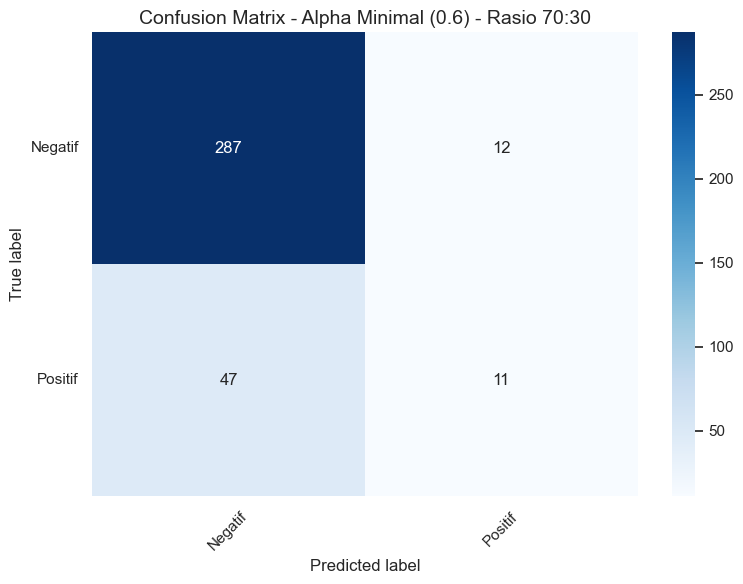

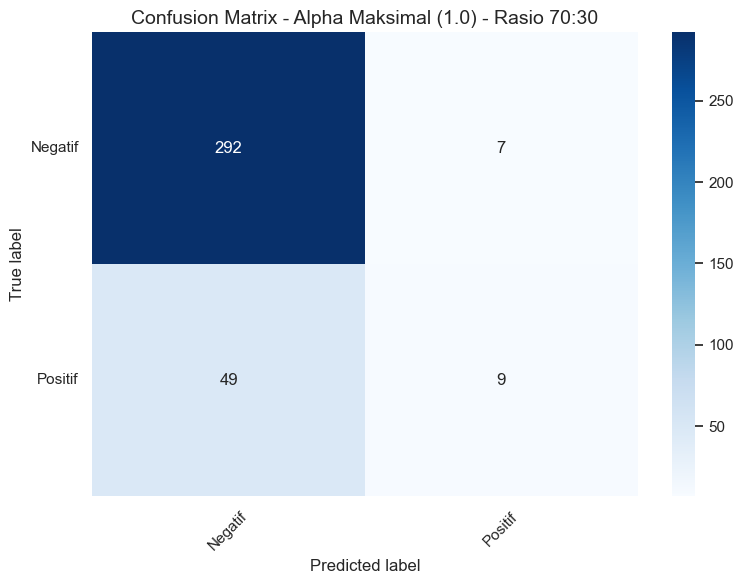


=== Confusion Matrix untuk Rasio Data 80:20 ===


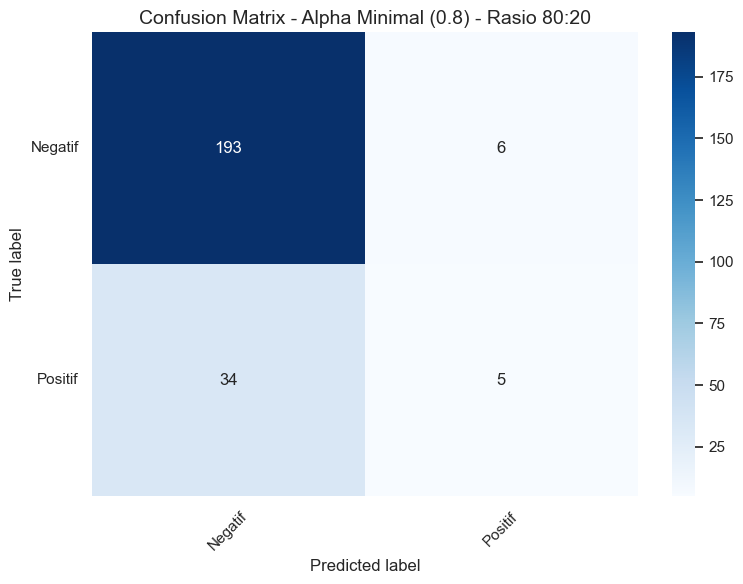

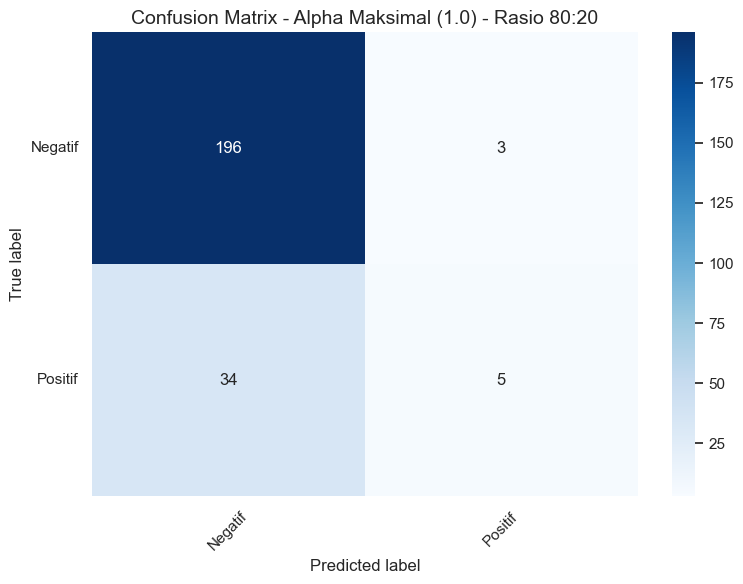


=== Confusion Matrix untuk Rasio Data 90:10 ===


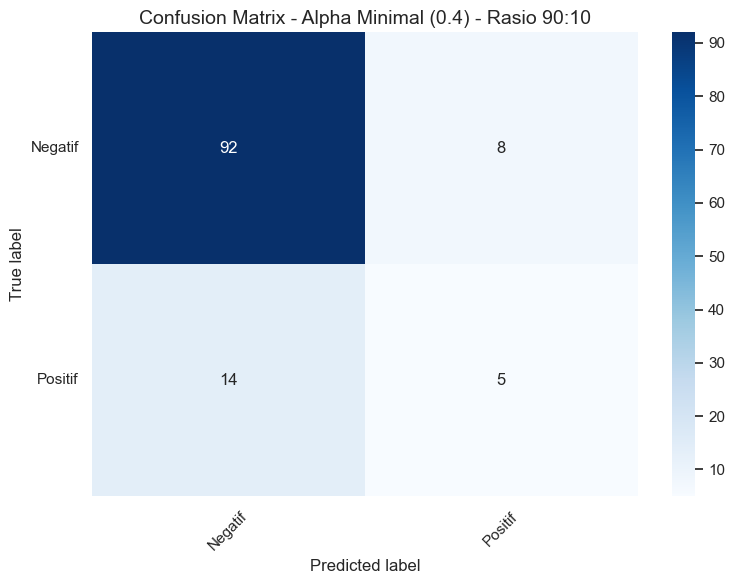

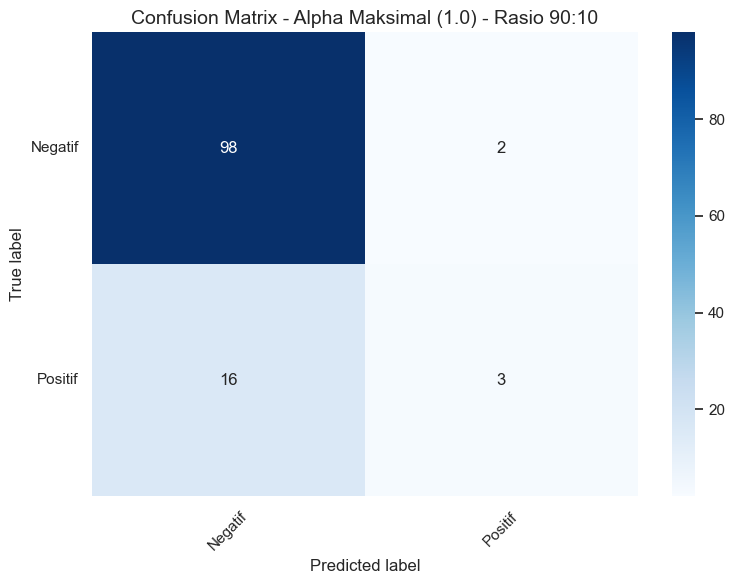

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Fungsi untuk menampilkan confusion matrix dengan seaborn
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes, 
                cbar=True, linewidths=0, linecolor='white')
    
    plt.title(title, fontsize=14)
    plt.xlabel('Predicted label', fontsize=12)
    plt.ylabel('True label', fontsize=12)
    plt.xticks(rotation=45)  
    plt.yticks(rotation=0)   
    plt.tight_layout()       
    plt.show()

# 6.11.1. Confusion Matrix Model
for split_data in data_splits:
    ratio = split_data['ratio']
    X_test_vec = split_data['X_test_vec']
    y_test = split_data['y_test']
    
    print(f"\n=== Confusion Matrix untuk Rasio Data {ratio} ===")
    
    # Confusion Matrix untuk model dengan alpha minimal
    best_mnb_min = split_data['best_mnb_min']
    y_pred_min = best_mnb_min.predict(X_test_vec)
    plot_confusion_matrix(
        y_test, y_pred_min, 
        classes=best_mnb_min.classes_, 
        title=f'Confusion Matrix - Alpha Minimal ({best_mnb_min.alpha}) - Rasio {ratio}'
    )
    
    # Confusion Matrix untuk model dengan alpha maksimal
    best_mnb_max = split_data['best_mnb_max']
    y_pred_max = best_mnb_max.predict(X_test_vec)
    plot_confusion_matrix(
        y_test, y_pred_max, 
        classes=best_mnb_max.classes_, 
        title=f'Confusion Matrix - Alpha Maksimal ({best_mnb_max.alpha}) - Rasio {ratio}'
    )
